<a href="https://colab.research.google.com/github/BrunuCosta/alzheimer_clf/blob/main/alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
# Bibliotecas essenciais
import pandas as pd  # Manipulação de tabelas de dados
import numpy as np   # Operações matemáticas e arrays
import matplotlib.pyplot as plt  # Criação de gráficos
import seaborn as sns  # Gráficos estatísticos mais bonitos

# Ferramentas de Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split  # Para dividir dados em treino/teste
from sklearn.ensemble import RandomForestClassifier   # Algoritmo de Floresta Aleatória
from sklearn.neighbors import KNeighborsClassifier    # Algoritmo K-Vizinhos Mais Próximos (KNN)
from sklearn.neural_network import MLPClassifier      # Rede Neural (Multilayer Perceptron)
from sklearn.dummy import DummyClassifier             # Modelo "bobo" para comparação base
from sklearn.tree import DecisionTreeClassifier       # Árvore de Decisão
from sklearn.preprocessing import StandardScaler      # Para normalizar os dados (colocar na mesma escala)
from sklearn.metrics import accuracy_score, confusion_matrix # Métricas de avaliação

In [2]:
# Leitura dos dados
dados_alzheimer = pd.read_csv("dados/alzheimers_disease_data.csv")

# Remove colunas de identificação (ID do paciente e do médico) pois não influenciam no diagnóstico biológico
dados_alzheimer.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)

# Mostra as 5 primeiras linhas para conferência
dados_alzheimer.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [3]:
#Tratamento de dados

# Separa as variáveis explicativas (Z) do alvo (w - Diagnóstico)
Z = dados_alzheimer.drop('Diagnosis', axis=1)
w = dados_alzheimer['Diagnosis']

# Converte colunas de texto para números (One-Hot Encoding), se houver
Z = pd.get_dummies(Z, drop_first=True)

# Treina uma Floresta Aleatória para calcular a importância de cada característica
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(Z, w) 

# Extrai a importância calculada pelo modelo
importances = modelo_rf.feature_importances_

# Cria uma tabela organizando: Nome da Coluna vs. Importância
feature_names = Z.columns
feature_importances_df = pd.DataFrame({
    'Coluna': feature_names,
    'Importância': importances
})

# Ordena da mais importante para a menos importante
feature_importances_df = feature_importances_df.sort_values(
    by='Importância',
    ascending=False
)

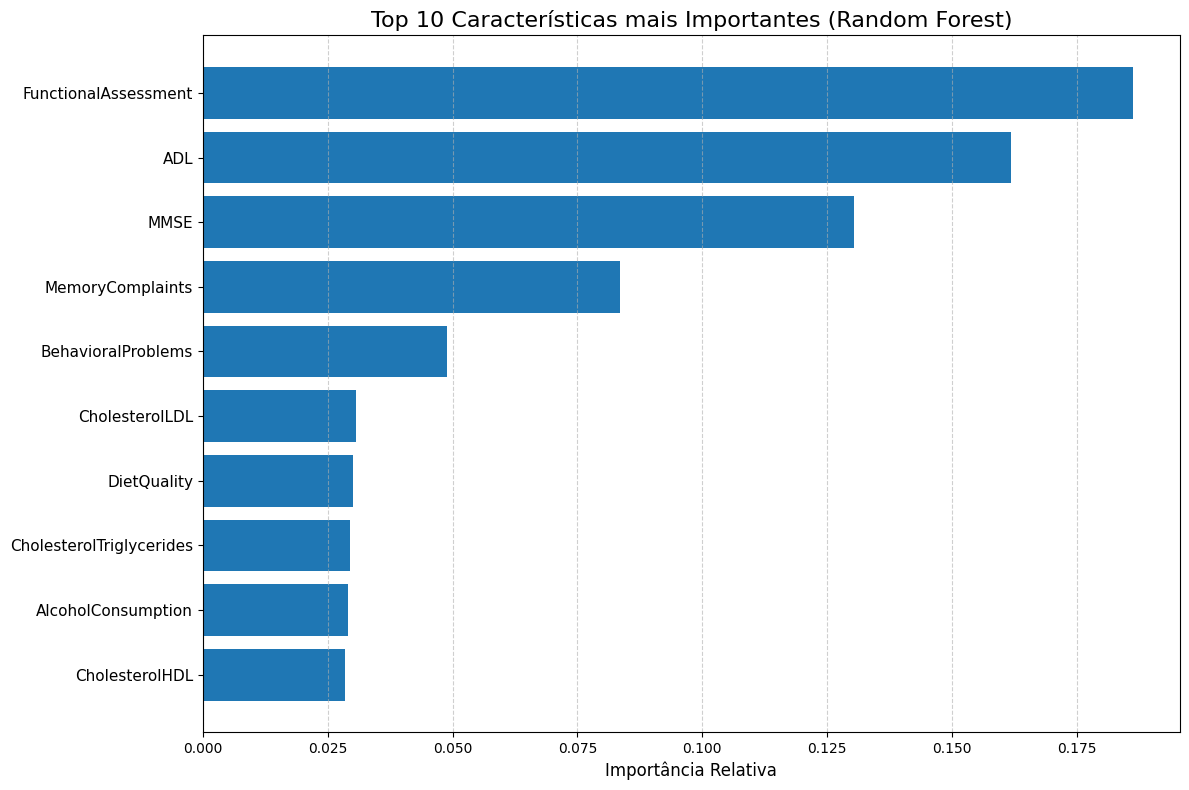

In [4]:
#Gráfico de influências
# Define quantas características mostrar no gráfico
N_TOP = 10
top_features = feature_importances_df.head(N_TOP)

# Ordena para o gráfico ficar bonito (barras crescentes)
top_features_sorted = top_features.sort_values(by='Importância', ascending=True)

plt.figure(figsize=(12, 8)) 

# Cria o gráfico de barras horizontais
plt.barh(top_features_sorted['Coluna'], top_features_sorted['Importância'], color='#1f77b4')

plt.title(f'Top {N_TOP} Características mais Importantes (Random Forest)', fontsize=16)
plt.xlabel('Importância Relativa', fontsize=12)

# Adiciona linhas de grade para facilitar a leitura
plt.grid(axis='x', linestyle='--', alpha=0.6) 
plt.xticks(fontsize=10)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

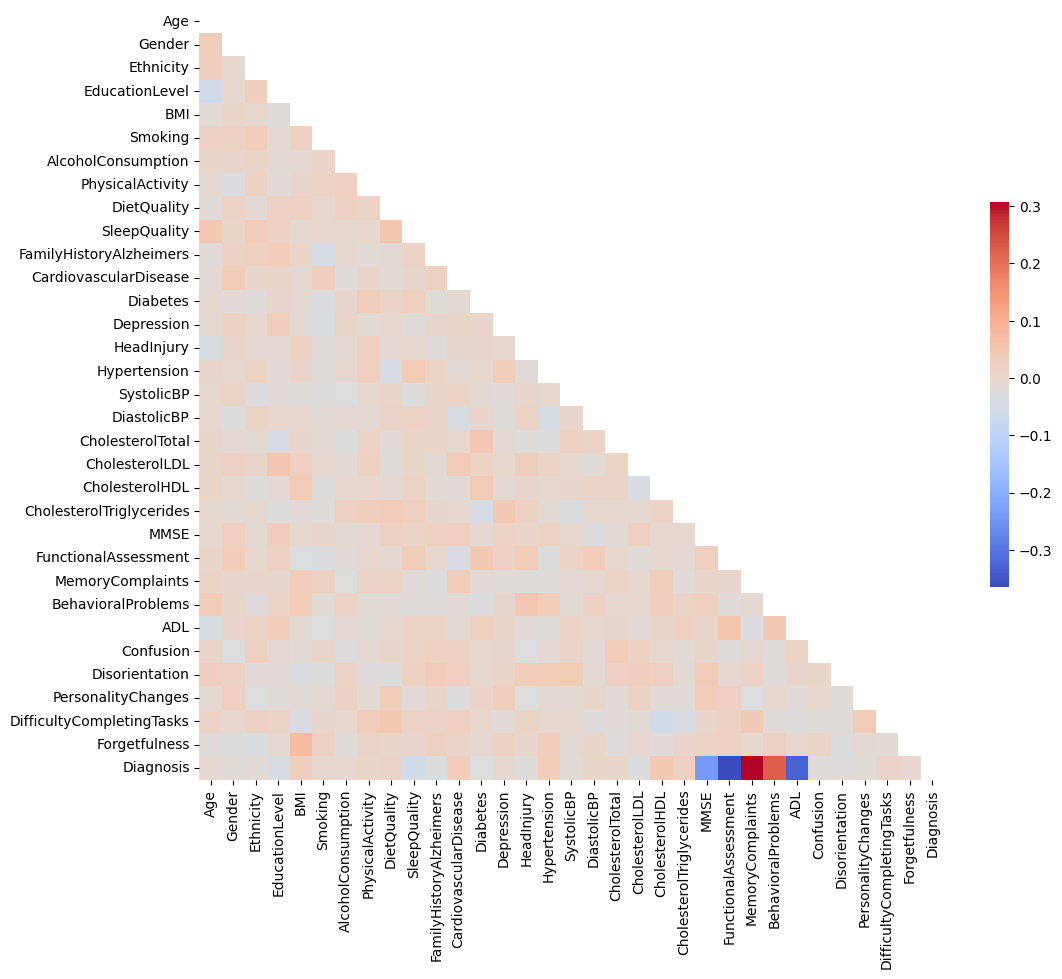

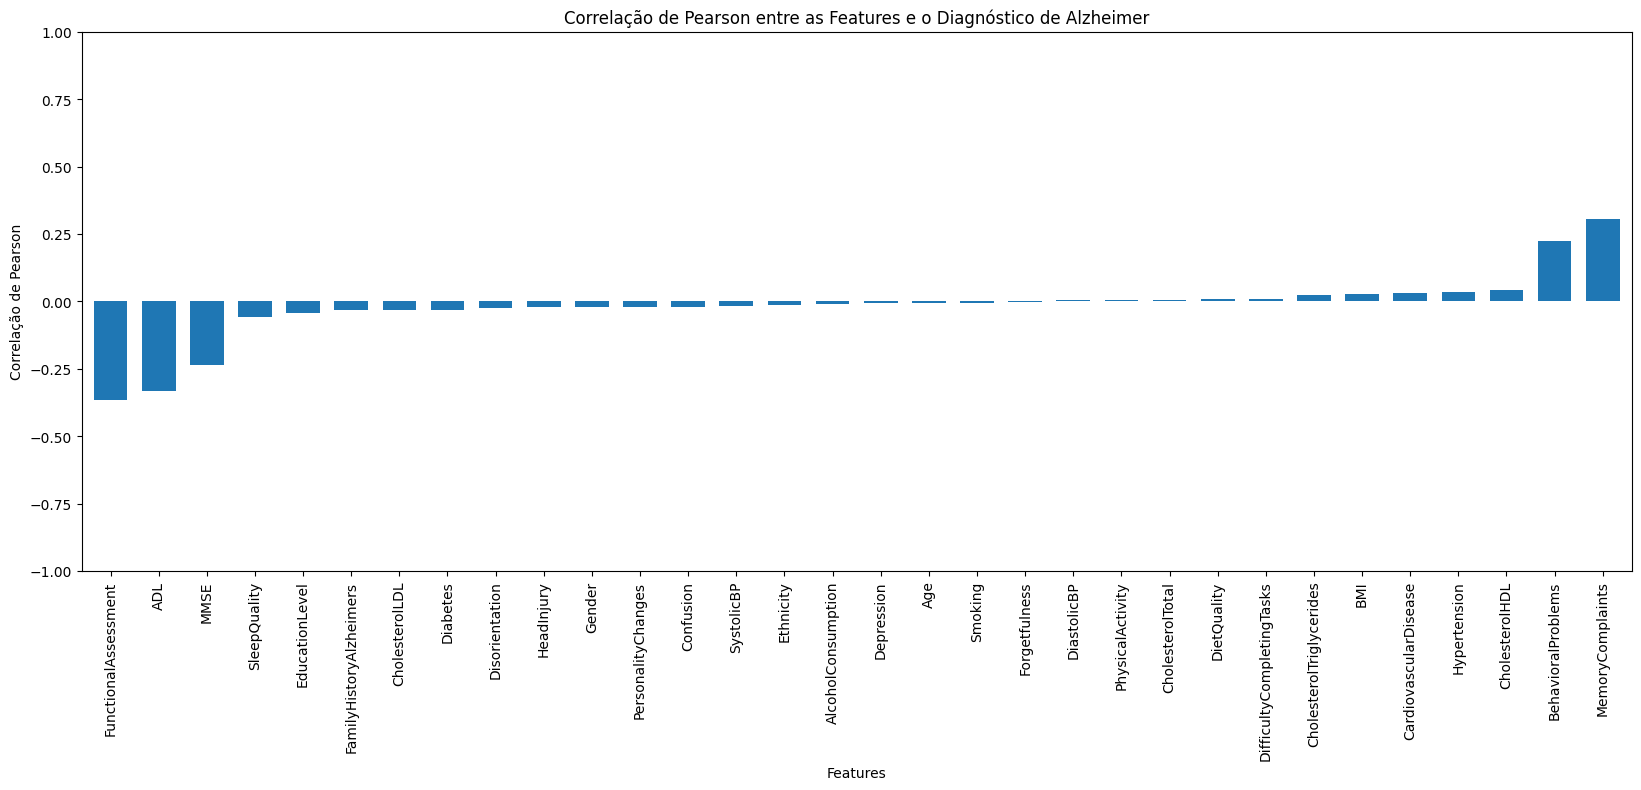

In [5]:
# Identifica colunas numéricas (muitos valores distintos) e categóricas
colunas_numericas = [col for col in dados_alzheimer.columns if dados_alzheimer[col].nunique() > 10]
colunas_categoricas = dados_alzheimer.columns.difference(colunas_numericas).difference(['Diagnosis']).to_list()

# --- Mapa de Calor (Heatmap) ---
# Cria uma máscara para mostrar apenas metade do triângulo (evita duplicidade visual)
mask = np.triu(np.ones_like(dados_alzheimer.corr(), dtype=bool))

plt.figure(figsize=(12, 10))
# Gera o mapa de cores: Vermelho (correlação alta) e Azul (correlação baixa/inversa)
sns.heatmap(dados_alzheimer.corr(), cmap="coolwarm", cbar_kws={"shrink": .5}, mask=mask)
plt.show()

# --- Gráfico de Barras de Correlação ---
# Calcula a correlação de todas as variáveis com o 'Diagnosis' e ordena
correlations = dados_alzheimer.corr(numeric_only=True)['Diagnosis'][:-1].sort_values()

plt.figure(figsize=(20, 7))
ax = correlations.plot(kind='bar', width=0.7)
ax.set(ylim=[-1, 1], ylabel='Correlação de Pearson', xlabel='Features', 
       title='Correlação de Pearson entre as Features e o Diagnóstico de Alzheimer')
plt.show()

In [6]:
# Processamento dos dados para aplicar o algoritmo

# Separa novamente X (dados) e y (respostas)
X, y = dados_alzheimer.drop(columns='Diagnosis'), dados_alzheimer["Diagnosis"]

# Divide os dados: 50% para treinar o modelo, 50% para testar se ele aprendeu
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, shuffle=False)

# Normalização (StandardScaler): Transforma os dados para terem média 0 e desvio padrão 1
scaler = StandardScaler()
colunas = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 
           'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 
           'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']

# Aplica a normalização nos dados de treino e replica a mesma regra para os de teste
X_train[colunas] = scaler.fit_transform(X_train[colunas])
X_test[colunas] = scaler.transform(X_test[colunas])

In [7]:
# Parâmetros

# K-vizinhos
k = 9 # Número de vizinhos a consultar
metrica_distancia = 'manhattan' # Tipo de régua para medir distância

# Parâmetros para Rede Neural (MLP)
camadas = (3, 2) # Duas camadas escondidas com 3 e 2 neurônios
taxa_aprendizado = 0.1
maximo_iteracoes = 2000

# Parâmetros para Árvore de Decisão
criterio = 'gini' # Método de divisão dos nós
profundidade = 3 # Altura máxima da árvore

In [8]:
# Aplicação dos algorítmos

# 1. Dummy (Linha de base)
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
dummy_acc = accuracy_score(y_test, y_pred_dummy) * 100

# 2. KNN
knn_clf = KNeighborsClassifier(n_neighbors=k, metric=metrica_distancia)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred_knn) * 100

# 3. Rede Neural (MLP)
mlp_clf = MLPClassifier(hidden_layer_sizes=camadas, learning_rate_init=taxa_aprendizado,
                        max_iter=maximo_iteracoes, activation='relu', solver='sgd',
                        random_state=42, momentum=0)
mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp) * 100

# 4. Árvore de Decisão
tree_clf = DecisionTreeClassifier(criterion=criterio, max_depth=profundidade)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
tree_acc = accuracy_score(y_test, y_pred_tree) * 100

# Exibe os resultados
print(f"""Precisão:
Dummy (chute): {dummy_acc:.2f}%
k-vizinhos: {knn_acc:.2f}%
Rede Multicamadas: {mlp_acc:.2f}%
Árvore de decisão: {tree_acc:.2f}%
""")

Precisão:
Dummy (chute): 63.26%
k-vizinhos: 74.88%
Rede Multicamadas: 81.86%
Árvore de decisão: 84.56%



In [9]:
# Matrizes de confusão
# Cria dataframes estilizados para as matrizes de confusão
df_knn = pd.DataFrame(confusion_matrix(y_test, y_pred_knn),
                      index=[['Real']*2, ['Negativo', 'Positivo']],
                      columns=[['Previsão']*2, ['Negativo', 'Positivo']]).style.set_caption("K-Vizinhos")

df_mlp = pd.DataFrame(confusion_matrix(y_test, y_pred_mlp),
                      index=[['Real']*2, ['Negativo', 'Positivo']],
                      columns=[['Previsão']*2, ['Negativo', 'Positivo']]).style.set_caption("Rede Multicamadas")

df_tree = pd.DataFrame(confusion_matrix(y_test, y_pred_tree),
                      index=[['Real']*2, ['Negativo', 'Positivo']],
                      columns=[['Previsão']*2, ['Negativo', 'Positivo']]).style.set_caption("Árvore de Decisão")

display(df_knn)

display(df_mlp)

display(df_tree)




In [10]:
# Função genérica para treinar e avaliar qualquer modelo

def avaliar_modelo(nome, modelo, X_train, y_train, X_test, y_test, mostrar=True):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    
    if mostrar:
        print(f"{nome} - acurácia: {acc:.2f}%")
    
    return acc, y_pred


In [11]:
# Parameter study - KNN

ks = [1, 3, 5, 7, 9, 11, 13, 15]
metricas = ['euclidean', 'manhattan']

resultados_knn = []

# Loop para testar todas as combinações
for k_ in ks:
    for metrica in metricas:
        knn = KNeighborsClassifier(n_neighbors=k_, metric=metrica)
        acc, _ = avaliar_modelo(
            nome=f"KNN (k={k_}, metric={metrica})",
            modelo=knn,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            mostrar=False  # deixa False pra não floodar a saída
        )
        resultados_knn.append({
            "k": k_,
            "metrica": metrica,
            "acuracia": acc
        })

df_resultados_knn = (
    pd.DataFrame(resultados_knn)
    .sort_values("acuracia", ascending=False)
    .reset_index(drop=True)  # zera o índice
)

# adiciona coluna de ranking (1 = melhor combinação)
df_resultados_knn.insert(0, "rank", range(1, len(df_resultados_knn) + 1))

display(df_resultados_knn.head(10))  # top 10 combinações

best_knn_cfg = df_resultados_knn.iloc[0]
best_knn_cfg


,rank,k,metrica,acuracia
0,1,11,manhattan,75.162791
1,2,15,manhattan,75.162791
2,3,9,manhattan,74.883721
3,4,13,manhattan,74.883721
4,5,7,manhattan,74.511628
5,6,9,euclidean,73.860465
6,7,3,manhattan,73.674419
7,8,5,manhattan,73.674419
8,9,13,euclidean,73.488372
9,10,11,euclidean,73.302326


rank                1
k                  11
metrica     manhattan
acuracia    75.162791
Name: 0, dtype: object

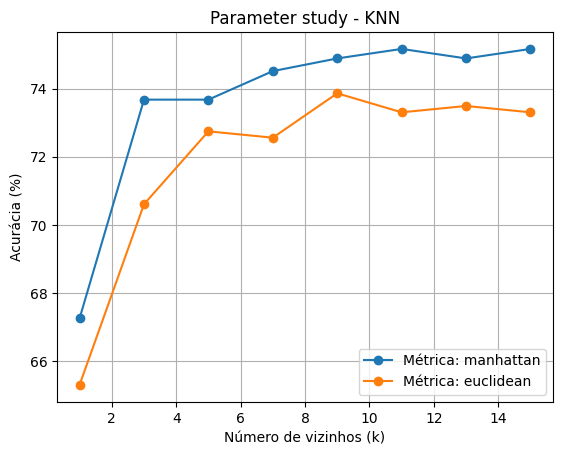

In [12]:
# Garantir índice resetado (opcional, só pra ficar bonito)
df_knn_plot = df_resultados_knn.reset_index(drop=True)

plt.figure()
for metrica in df_knn_plot['metrica'].unique():
    # ordenar por k dentro de cada métrica
    subset = df_knn_plot[df_knn_plot['metrica'] == metrica].sort_values('k')
    plt.plot(subset['k'], subset['acuracia'], marker='o', label=f"Métrica: {metrica}")

plt.xlabel("Número de vizinhos (k)")
plt.ylabel("Acurácia (%)")
plt.title("Parameter study - KNN")
plt.grid(True)
plt.legend()
plt.show()


In [13]:
# Parameter study - Rede Multicamadas (MLP)

estruturas = [
    (5,),
    (10,),
    (20,),
    (10, 5),
    (20, 10)
]

taxas_aprendizado = [0.001, 0.01, 0.1]

resultados_mlp = []

for camadas_ in estruturas:
    for lr in taxas_aprendizado:
        mlp = MLPClassifier(
            hidden_layer_sizes=camadas_,
            learning_rate_init=lr,
            max_iter=maximo_iteracoes,  # você já definiu essa variável antes
            activation='relu',
            solver='sgd',
            random_state=42,
            momentum=0,
        )
        acc, _ = avaliar_modelo(
            nome=f"MLP (layers={camadas_}, lr={lr})",
            modelo=mlp,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            mostrar=False
        )
        resultados_mlp.append({
            "camadas": camadas_,
            "taxa_aprendizado": lr,
            "acuracia": acc
        })

df_resultados_mlp = (
    pd.DataFrame(resultados_mlp)
    .sort_values("acuracia", ascending=False)
    .reset_index(drop=True)  # zera o índice
)

# adiciona coluna de ranking (1 = melhor acurácia)
df_resultados_mlp.insert(0, "rank", range(1, len(df_resultados_mlp) + 1))

display(df_resultados_mlp.head(10))

best_mlp_cfg = df_resultados_mlp.iloc[0]
best_mlp_cfg


,rank,camadas,taxa_aprendizado,acuracia
0,1,"(5,)",0.01,84.279070
1,2,"(10, 5)",0.01,83.906977
2,3,"(10, 5)",0.10,83.627907
3,4,"(5,)",0.10,83.255814
4,5,"(20,)",0.01,83.255814
5,6,"(20, 10)",0.01,82.976744
6,7,"(20, 10)",0.10,82.790698
7,8,"(10,)",0.01,82.697674
8,9,"(10,)",0.10,82.697674
9,10,"(20,)",0.10,82.604651


rank                       1
camadas                 (5,)
taxa_aprendizado        0.01
acuracia            84.27907
Name: 0, dtype: object

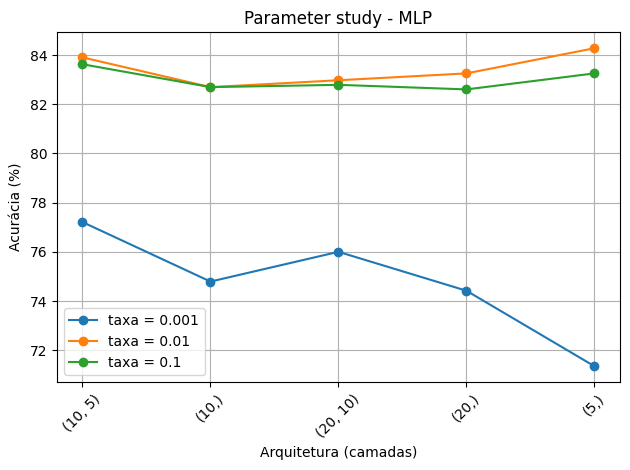

In [14]:
df_mlp_plot = df_resultados_mlp.reset_index(drop=True).copy()
df_mlp_plot['camadas_str'] = df_mlp_plot['camadas'].astype(str)

pivot_mlp = df_mlp_plot.pivot(
    index='camadas_str',
    columns='taxa_aprendizado',
    values='acuracia'
)

plt.figure()
for lr in pivot_mlp.columns:
    plt.plot(pivot_mlp.index, pivot_mlp[lr], marker='o', label=f"taxa = {lr}")

plt.xlabel("Arquitetura (camadas)")
plt.ylabel("Acurácia (%)")
plt.title("Parameter study - MLP")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# Parameter study - Árvore de Decisão

criterios = ['gini', 'entropy']
profundidades = [2, 3, 4, 5, 6, None]  # None = sem limite

resultados_tree = []

for crit in criterios:
    for prof in profundidades:
        tree = DecisionTreeClassifier(
            criterion=crit,
            max_depth=prof,
            random_state=42
        )
        acc, _ = avaliar_modelo(
            nome=f"Tree (crit={crit}, max_depth={prof})",
            modelo=tree,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            mostrar=False
        )
        resultados_tree.append({
            "criterio": crit,
            "max_depth": prof,
            "acuracia": acc
        })

df_resultados_tree = (
    pd.DataFrame(resultados_tree)
    .sort_values("acuracia", ascending=False)
    .reset_index(drop=True)
)

df_resultados_tree.insert(0, "rank", range(1, len(df_resultados_tree) + 1))

display(df_resultados_tree.head(10))


best_tree_cfg = df_resultados_tree.iloc[0]
best_tree_cfg


,rank,criterio,max_depth,acuracia
0,1,entropy,6.0,91.162791
1,2,entropy,NaN,91.069767
2,3,gini,5.0,90.976744
3,4,entropy,5.0,90.976744
4,5,gini,6.0,90.697674
5,6,gini,NaN,90.604651
6,7,gini,4.0,90.325581
7,8,entropy,4.0,88.372093
8,9,gini,3.0,84.558140
9,10,entropy,3.0,81.581395


rank                 1
criterio       entropy
max_depth          6.0
acuracia     91.162791
Name: 0, dtype: object

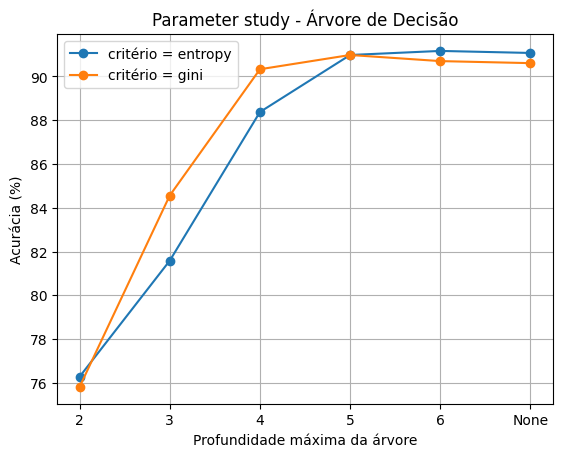

In [16]:
df_tree_plot = df_resultados_tree.reset_index(drop=True).copy()

# criar uma coluna numérica para a profundidade, trocando None/NaN por um valor maior
depth_col = df_tree_plot['max_depth'].copy()
max_real_depth = depth_col.dropna().max()      # 6.0 no seu caso
depth_col = depth_col.fillna(max_real_depth + 1)  # None -> 7.0
df_tree_plot['depth_plot'] = depth_col

plt.figure()
for crit in df_tree_plot['criterio'].unique():
    subset = df_tree_plot[df_tree_plot['criterio'] == crit].sort_values('depth_plot')
    plt.plot(subset['depth_plot'], subset['acuracia'], marker='o', label=f"critério = {crit}")

# valores que vão aparecer no eixo X
valores_x = [2, 3, 4, 5, 6, max_real_depth + 1]
labels_x  = ["2", "3", "4", "5", "6", "None"]   # rótulo bonitinho

plt.xticks(valores_x, labels_x)

plt.xlabel("Profundidade máxima da árvore")
plt.ylabel("Acurácia (%)")
plt.title("Parameter study - Árvore de Decisão")
plt.grid(True)
plt.legend()
plt.show()

